In [222]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [223]:
torch.manual_seed(42)

In [224]:
df = pd.read_csv('iris.csv')
df.head()

,sepal_length,sepal_width,petal_length,petal_width,species
0,5.1,3.5,1.4,0.2,Iris-setosa
1,4.9,3.0,1.4,0.2,Iris-setosa
2,4.7,3.2,1.3,0.2,Iris-setosa
3,4.6,3.1,1.5,0.2,Iris-setosa
4,5.0,3.6,1.4,0.2,Iris-setosa


In [225]:
X = df.drop('species' , axis=1)
y = df['species']

In [226]:
scaler = StandardScaler()
X = scaler.fit_transform(X)

In [227]:
encoder = OneHotEncoder(sparse=False)
y_encoded = encoder.fit_transform(y.values.reshape(-1, 1))

c:\Users\Win10\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [228]:
X_tensor = torch.tensor(X, dtype=torch.float32)
y_tensor = torch.tensor(y_encoded, dtype=torch.float32)

In [229]:
dataset = TensorDataset(X_tensor, y_tensor)
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

In [230]:
class IrisNN(nn.Module):
    def __init__(self):
        super(IrisNN, self).__init__()
        self.layer1 = nn.Linear(4, 128)
        self.bn1 = nn.BatchNorm1d(128)  
        self.dropout1 = nn.Dropout(0.5)  

        self.layer2 = nn.Linear(128, 64)
        self.bn2 = nn.BatchNorm1d(64)  
        self.dropout2 = nn.Dropout(0.3)  

        self.layer3 = nn.Linear(64, 32)
        self.bn3 = nn.BatchNorm1d(32) 

        self.layer4 = nn.Linear(32, 16)
        self.bn4 = nn.BatchNorm1d(16)  

        self.output = nn.Linear(16, 3)  

    def forward(self, x):

        # Layer 1
        x = torch.relu(self.bn1(self.layer1(x)))
        x = self.dropout1(x)  

        # Layer 2
        x = torch.relu(self.bn2(self.layer2(x)))
        x = self.dropout2(x)  

        # Layer 3
        x = torch.relu(self.bn3(self.layer3(x)))

        # Layer 4
        x = torch.relu(self.bn4(self.layer4(x)))

        # Output Layer 
        return torch.softmax(self.output(x), dim=1)

model = IrisNN()

In [231]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [232]:
epochs = 300
train_losses, test_losses = [], []

for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for X_batch, y_batch in train_loader:
        optimizer.zero_grad()
        y_pred = model(X_batch)
        loss = criterion(y_pred, torch.argmax(y_batch, dim=1))
        loss.backward()
        optimizer.step()
        train_loss += loss.item()

    train_losses.append(train_loss / len(train_loader))

    model.eval()
    test_loss = 0.0
    with torch.no_grad():
        for X_batch, y_batch in test_loader:
            y_pred = model(X_batch)
            loss = criterion(y_pred, torch.argmax(y_batch, dim=1))
            test_loss += loss.item()

    test_losses.append(test_loss / len(test_loader))
    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")

Epoch 1/300, Train Loss: 8.3701, Test Loss: 2.1852
Epoch 2/300, Train Loss: 7.8491, Test Loss: 2.0845
Epoch 3/300, Train Loss: 7.3132, Test Loss: 1.9412
Epoch 4/300, Train Loss: 7.1386, Test Loss: 1.8300
Epoch 5/300, Train Loss: 7.0829, Test Loss: 1.7186
Epoch 6/300, Train Loss: 6.7627, Test Loss: 1.6749
Epoch 7/300, Train Loss: 6.5028, Test Loss: 1.6573
Epoch 8/300, Train Loss: 6.3020, Test Loss: 1.6236
Epoch 9/300, Train Loss: 6.3664, Test Loss: 1.5963
Epoch 10/300, Train Loss: 6.1913, Test Loss: 1.5717
Epoch 11/300, Train Loss: 6.2300, Test Loss: 1.5078
Epoch 12/300, Train Loss: 6.0994, Test Loss: 1.4870
Epoch 13/300, Train Loss: 6.0848, Test Loss: 1.4978
Epoch 14/300, Train Loss: 6.2146, Test Loss: 1.4536
Epoch 15/300, Train Loss: 5.7098, Test Loss: 1.4678
Epoch 16/300, Train Loss: 5.4725, Test Loss: 1.4436
Epoch 17/300, Train Loss: 6.0058, Test Loss: 1.4208
Epoch 18/300, Train Loss: 5.6717, Test Loss: 1.4129
Epoch 19/300, Train Loss: 5.5404, Test Loss: 1.3970
Epoch 20/300, Train L

In [233]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for X_batch, y_batch in test_loader:
        y_pred = model(X_batch)
        all_preds.extend(torch.argmax(y_pred, dim=1).numpy())
        all_labels.extend(torch.argmax(y_batch, dim=1).numpy())

In [234]:
accuracy = accuracy_score(all_labels, all_preds)
print(f"Accuracy: {accuracy * 100:.2f}%")

Accuracy: 96.67%


In [235]:
print("Classification Report:")
print(classification_report(all_labels, all_preds, target_names= y.unique().astype(str) ))

Classification Report:
                 precision    recall  f1-score   support

    Iris-setosa       1.00      1.00      1.00         6
Iris-versicolor       1.00      0.90      0.95        10
 Iris-virginica       0.93      1.00      0.97        14

       accuracy                           0.97        30
      macro avg       0.98      0.97      0.97        30
   weighted avg       0.97      0.97      0.97        30



In [236]:
conf_matrix = confusion_matrix(all_labels, all_preds)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[ 6  0  0]
 [ 0  9  1]
 [ 0  0 14]]


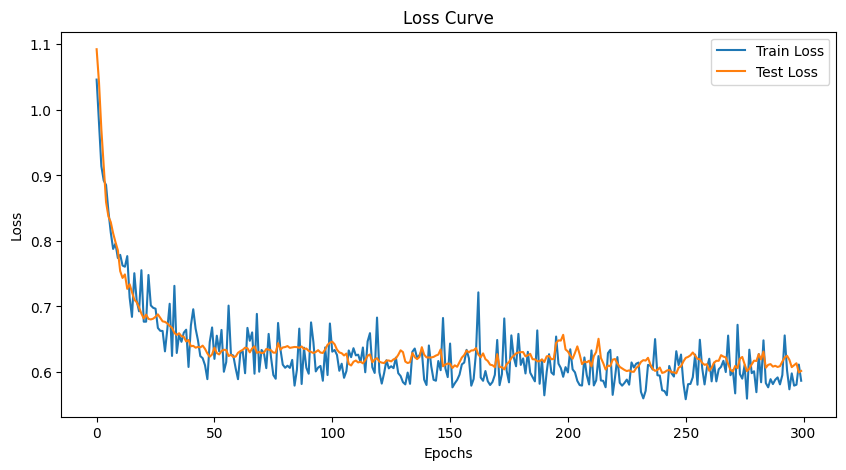

In [237]:
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Train Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')
plt.show()

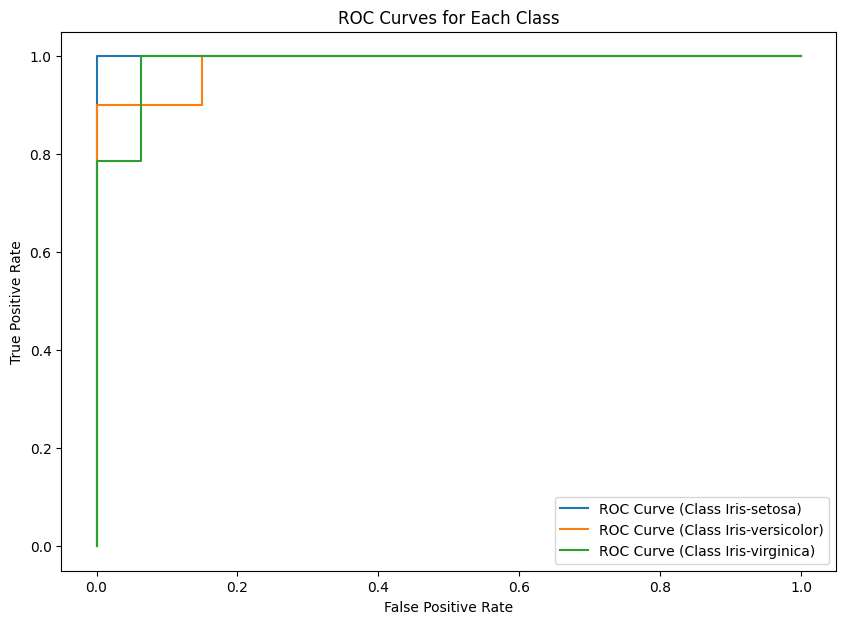

In [238]:
y_probs = np.vstack([model(X_tensor).detach().numpy() for X_tensor, _ in test_loader])
y_true = np.vstack([y.numpy() for _, y in test_loader])

plt.figure(figsize=(10, 7))
for i in range(3):
    fpr, tpr, _ = roc_curve(y_true[:, i], y_probs[:, i])
    plt.plot(fpr, tpr, label=f"ROC Curve (Class {y.unique().astype(str)[i]})")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curves for Each Class")
plt.legend()
plt.show()
